# Computer price regression


## Modelling objective


> To build an **optimal** and accurate model to estimate computer prices, by using Root Mean Squared Error (RMSE) and $R^2$ as our main metrics

## Problem task & Background research

> Can we utilize machine learning to help PC buyers determine the price of a computer given its specifications?

When we purchase PCs, each of us tries to have the best equipment at the lowest possible price.
PCs are used in a variety of settings, such as at work, educational purposes, gaming, web browsing, personal multimedia, or for general home computer use.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
from IPython.display import display
import warnings
from statsmodels.api import qqplot
warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline


In [2]:
# pip install phik
# Please install
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

In [3]:
# Regression models
from sklearn.svm import LinearSVR,SVR,NuSVR
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso,BayesianRidge,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor,BaggingRegressor,AdaBoostRegressor


# Tools to help with data preprocessing
from sklearn.pipeline import make_pipeline,Pipeline,FeatureUnion,make_union
from sklearn.compose import ColumnTransformer,make_column_transformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PolynomialFeatures, OneHotEncoder, PowerTransformer
from sklearn.decomposition import PCA


# Hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Feature Selection
from sklearn.feature_selection import SelectKBest,SelectFromModel, RFECV, SelectKBest, f_regression, mutual_info_regression, RFE

# model evaluation
from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve,validation_curve
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error,SCORERS,make_scorer

# Feature importance for interpretability
from sklearn.inspection import permutation_importance

# Visualisation
from sklearn.tree import plot_tree,export_graphviz

#Base
from sklearn.base import BaseEstimator, TransformerMixin


## Reading from csv file

This dataset contains the aspects/**specifications** and cost of computers collected from a PC website
* Target variable is `Price ($)`
* We can see that product ID may not provide any information towards our target variable
* We may have to perform some potential feature engineering steps on some of the component features like CPU/Hard disk.

In [4]:
pc_df = pd.read_csv('datasets/pc_data.csv',sep=',', na_values='?')
# Denote null values as ?
pc_df.head()

,Product ID,Brand,Type,Screen Size,Screen Specs,CPU,RAM,Hard Disk,GPU,Operating System,Weight,Price ($)
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,3568.93416
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,2394.77616
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,1531.80000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,6759.76680
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,4804.79040


In [5]:
rstate = np.random.RandomState(1)

## Data dictonary:
1. Product ID: unique identifier ranging from 0 to 15319
2. Brand: Brand of PC; Apple, HP,etc.
3. Type: PC type such as `notebook, ultrabook`
4. Screen Size: Size of PC screen; Usually measured diagonally from corner to corner.
5. Screen Specs: PC specs with resolution in pixels. Format: `(width x height)`
6. CPU: CPU (aka Central processing unit) information of pc
7. RAM: Random access memory info of PC.
8. Hard disk: Hard disk information of PC.
9. GPU: Graphic card of PC
10. Operating system: OS of pc; `windows, macOS, etc`
11. Weight: Weight of PC
>12. Price: Price of pc



### Exploratory data analysis
- EDA will be carried out to discover characteristics of the data
- Develop a better understanding of data before we build the model

In [6]:
pc_EDA = pc_df.copy()

In [7]:
display(pc_EDA.describe().drop('Product ID', axis=1).T)
# Drop product id as it represents more of a counter
display(pc_EDA.info())

,count,mean,std,min,25%,50%,75%,max
Screen Size,15320.0,15.016475,1.425779,10.100,14.000,15.600,15.60,18.400
Price ($),15320.0,3011.993343,1865.353614,463.536,1607.336,2614.426,3983.98,16259.336


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15320 entries, 0 to 15319
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product ID        15320 non-null  int64  
 1   Brand             15320 non-null  object 
 2   Type              15320 non-null  object 
 3   Screen Size       15320 non-null  float64
 4   Screen Specs      15320 non-null  object 
 5   CPU               15320 non-null  object 
 6   RAM               15320 non-null  object 
 7   Hard Disk         15320 non-null  object 
 8   GPU               15320 non-null  object 
 9   Operating System  15320 non-null  object 
 10  Weight            15320 non-null  object 
 11  Price ($)         15320 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 1.4+ MB


None

We observe that there are *no null values*, and few numerical variables at first.
- Dataset have 15320 rows and 12 columns.
- Standard deviation is very high for PC prices, suggests that the prices will vary significantly
- Median pc price is (2616) while maximum is 16k, suggests a right skewed distribution of prices. (observed from each quantiles as well)
- 50% of PCs cost more than $2614
- Possibly existance of outliers given such a distribution

- Median looks like a better central tendancy for PC prices in this case.
- Screen sizes are generally consistent, with similar mean and median, suggesting a symmetrical distribution
- Other possible numerical variables exist.


### Missing values analysis
- The dataset does not have missing values.


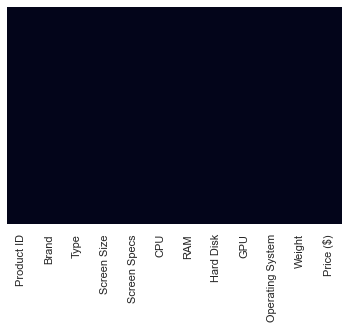

Product ID          0
Brand               0
Type                0
Screen Size         0
Screen Specs        0
CPU                 0
RAM                 0
Hard Disk           0
GPU                 0
Operating System    0
Weight              0
Price ($)           0
dtype: int64

In [8]:
sns.heatmap(pc_EDA.isnull(),yticklabels=False,cbar=False)
plt.show()
# No missing values.
pc_EDA.isnull().sum()

Observations from `Product ID`
- We can see that Product ID has 15320 unique classes, and may simply just be a representation of each row in the dataset.
- Unlikely to provide any value towards our target variable
- Hence dropping it

In [9]:
print(pc_EDA['Product ID'].nunique())

15320


### Target variable analysis
1. Price is very positively skewed to the right, with the existance of outliers. (shown via qqplot and histogram)
2. Posses a high Interquartile range
2. Outliers exist in the form of costly computers of over $10k
3. As mentioned earlier, median will then be used as central tendencies
3. Log transformation can help to convert skewed distribution to a near normal distribution
4. Can also help to treat outliers instead of removing outliers (valuable data).


IQR: 2376.6440000000002


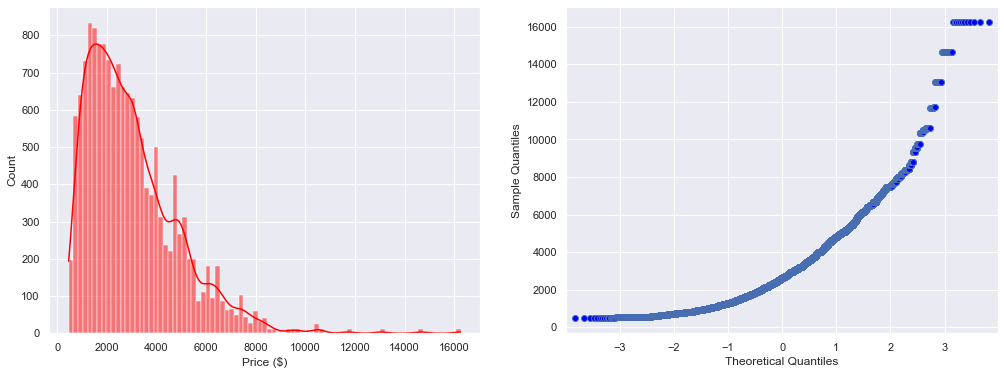

In [10]:
figdist, (axhist, axqq) = plt.subplots(1,2, figsize=(17,6))
# sns.set_context('notebook')
sns.histplot(data=pc_EDA,x='Price ($)',kde=True,color='red',ax=axhist)
qqplot(pc_EDA['Price ($)'],ax=axqq)
figdist.show()
print('IQR:',np.quantile(pc_EDA['Price ($)'], .75) -np.quantile(pc_EDA['Price ($)'],.25)  )
# Most laptops cost around 2k

Attempt to transform target variable
- Price now slightly follows a normal distribution, with majority of the outliers treated.
- This idea might help with the accuracy of the model later on

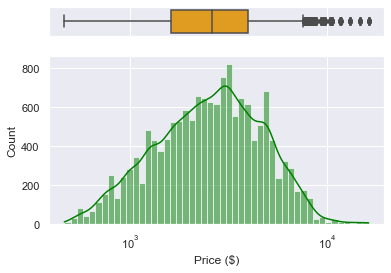

In [11]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.histplot(data=pc_EDA,x='Price ($)',kde=True,color='green',log_scale=True,ax=ax_hist)
sns.boxplot(data=pc_EDA, x="Price ($)", ax=ax_box,color='orange')
ax_box.set(xlabel='')
plt.show()
# Log transformation

### Analysing numerical features

We can see that several categorical columns contain a lot of unique categories. For example, CPU has 118 unique classes, GPU has 110. This poses a problem for us as it will be very hard to perform data analysis.
- Moreover, preprocessing steps like one hot encoding for ML models will result in high cardinality which we do not want.
- However, we can also 'unpack' from features, like specs of GPU/CPU, these features could definitely be of value for the model
- Given this we will perform **data cleansing and feature engineering**

In [12]:
# display(pc_EDA['CPU'].head())
for col in pc_EDA.columns:
    print(col,' ',pc_EDA[col].nunique())


Product ID   15320
Brand   19
Type   6
Screen Size   18
Screen Specs   40
CPU   118
RAM   9
Hard Disk   39
GPU   110
Operating System   9
Weight   179
Price ($)   9328


In [13]:
pc_EDA['CPU'].head()
# May be hard to analyse

0          Intel Core i5 2.3GHz
1          Intel Core i5 1.8GHz
2    Intel Core i5 7200U 2.5GHz
3          Intel Core i7 2.7GHz
4          Intel Core i5 3.1GHz
Name: CPU, dtype: object

> We will also perform EDA on newly created features.

# Feature engineering/splitting

| Newly created features | Information  |
| :--- | :--- |
|`CPU brand`| Refers to CPU Manufacturers {Intel, AMD,etc}|
|`Processor clock speed`|Determines how quick the CPU can retrieve and interpret instructions, measured in `GHz` |
|`Pixels (width)`| Screen width in pixels|
|`Pixels (height)`| Screen height in pixels|
|`Touchscreen`|Touchscreen or no? 1- `yes/true` 0- `no/false`|
|`IPS panel`|IPS panel or no? 1- `yes/true` 0- `no/false`|
|`CPU series`|Series of CPU {AMD A, Intel Core i5, Intel Core i7, etc}|
|`SSD`|SSD storage space of a computer in GB, 0 if the computer does not use SSD|
|`HDD`|HDD storage space of a computer in GB, 0 if the computer does not use HDD|
|`Flash`|Flash storage space of PC in GB, 0 if computer does not use Flash storage|
|`Hybrid`|Hybrid storage space of PC in GB, 0 if computer does not use Hybrid storage.|
|`Pixels per inch (ppi)`|Refers to individual pixels are displayed in one inch of a digital image|



Converting RAM and Weight to its numerical format, by removing GB and kg respectively
- Generally, the more RAM, the faster the hardware.

> ### Assistance from regex
1. Extracting first string from CPU to form `CPU brand`
2. Extracting the numerical value before `GHz` to form `Processor clock speed`
3. Extracting screen pixel width and height from the resolution format of *`width`*x*`height`* under `Screen Specs`
4. `Touchscreen` shows which computers are touchscreen or not.
5. `IPS Panel` shows which computers are IPS Panel or not.

In [14]:
pc_EDA['RAM'] = pc_EDA['RAM'].str.replace('GB', '').astype(int)
pc_EDA['Weight'] = pc_EDA['Weight'].str.replace('kg', '').astype(float)


# CPU Brand
pc_EDA['CPU brand'] = pc_EDA['CPU'].str.split(' ',expand=True)[0]


# Feature splitting for CPU, Screen Screen specs
pc_EDA['Processor clock speed'] = pc_EDA['CPU'].astype("string").str.extract('([0-9.]+)GHz' ,expand = False).astype(float)


# Resolution is in the form WidthxHeight
pc_EDA[['Pixels (width)', 'Pixels (height)']] = pc_EDA['Screen Specs'].str.extract(r'(\d+)[x](\d+)', expand=True).astype(int)

# 1 for rows with touch screen/ 0 without
pc_EDA['Touchscreen'] = pc_EDA['Screen Specs'].str.contains('Touchscreen', regex=False).astype(int)
pc_EDA['IPS Panel'] = pc_EDA['Screen Specs'].str.contains('IPS', regex=False).astype(int)

> ### Assistance from python re module
1. Use of re.findall/sub to extract CPU series by extensively cleaning `CPU` column
2. Replacing some duplicate names

In [15]:
# CPU cleaning, to extract series
clean1 = np.array(list(map(lambda x: re.findall('.*? \d+',x)[0].strip(), pc_EDA["CPU"] )))

clean2 = np.array(list(map(lambda y: re.sub(" \d+.*", "", y),clean1  )))
clean3 = np.array(list(map(lambda y: re.sub("-[a-zA-Z0-9 ]+", "", y),clean2)))
clean4 =pd.Series( np.array(list(map(lambda l: re.sub(' [Z,E,N][0-9]+', '', l), clean3) )))

clean4 = clean4.str.replace('(A[0-9]+)','')
clean4 = clean4.str.replace('Intel Core M M3','Intel Core M m3')
clean4 = clean4.str.replace('Intel Atom X5','Intel Atom x5')
clean4 = clean4.str.replace('Intel Core M M7', 'Intel Core M m7')
clean4 = clean4.str.replace('Samsung Cortex &', 'Samsung Cortex')
clean4[clean4 == 'AMD '] = clean4[clean4 == 'AMD ']  + 'A'
pc_EDA['CPU Series'] = clean4
display(pc_EDA['CPU Series'].unique())

array(['Intel Core i5', 'Intel Core i7', 'AMD A', 'Intel Core i3',
       'Intel Core M m3', 'Intel Atom x5', 'AMD E',
       'Intel Celeron Dual Core', 'AMD Ryzen', 'Intel Pentium Quad Core',
       'AMD FX', 'Intel Core M', 'Intel Xeon', 'Intel Celeron Quad Core',
       'Intel Atom', 'Intel Pentium Dual Core', 'Intel Core M m7',
       'Samsung Cortex'], dtype=object)

In [16]:
display(pc_EDA['Hard Disk'].unique())
display(pc_EDA['Hard Disk'].nunique())

array(['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD',
       '500GB HDD', '256GB Flash Storage', '1TB HDD',
       '32GB Flash Storage', '128GB SSD +  1TB HDD',
       '256GB SSD +  256GB SSD', '64GB Flash Storage',
       '256GB SSD +  1TB HDD', '256GB SSD +  2TB HDD', '32GB SSD',
       '2TB HDD', '64GB SSD', '1.0TB Hybrid', '512GB SSD +  1TB HDD',
       '1TB SSD', '256GB SSD +  500GB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  512GB SSD', '16GB SSD', '16GB Flash Storage',
       '512GB SSD +  256GB SSD', '512GB SSD +  2TB HDD',
       '64GB Flash Storage +  1TB HDD', '180GB SSD', '1TB HDD +  1TB HDD',
       '32GB HDD', '1TB SSD +  1TB HDD', '512GB Flash Storage',
       '128GB HDD', '240GB SSD', '8GB SSD', '508GB Hybrid', '1.0TB HDD',
       '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid'],
      dtype=object)

39

We notice that there are some duplicates such as 1.0 TB HDD and 1TB HDD which should be treated the same.
1. Replace all TB with 1000 GB.
2. Create 4 new features by extracting out the storage space, and inputting to its corresponding storage type.
3. For e.g -> Computer one will have 128 GB SSD. The storage space representation will look like:

In [17]:
pd.DataFrame([[128,0,0,0]], columns=['SSD', 'HDD', 'Flash', 'Hybrid'])

,SSD,HDD,Flash,Hybrid
0,128,0,0,0


In [18]:
pc_EDA['Hard Disk'] = pc_EDA['Hard Disk'].str.replace('.0', '',regex=False).str.replace('TB', '000GB').str.replace(' Storage' , '')
d = {'SSD' : [] , 'HDD' : [] , 'Flash': [] , 'Hybrid'  : []}
def edaCleanse(disk):
    if '+' in disk:
        splitted = list(map(lambda x : x.strip() , disk.split("+") ))
    else:
        splitted = [disk]
       
   
    if len(splitted) != 1 and  splitted[0].split(' ')[1] == splitted[1].split(" ")[1]:
        amount1,kind =  splitted[0].split(' ')
        amount2,_ = splitted[1].split(' ')
        d[kind].append(int(amount1.replace('GB' ,'')) + int(amount2.replace('GB' , '')))

    else:
        for drive in splitted:
            amount,kind =  drive.split(' ')
            d[kind].append(int(amount.replace('GB' ,'')))
   
    splitted  = list(map(lambda x : x.split(' ')[1] , splitted))
    for key in filter(lambda x: x  not in splitted,  d.keys()):

        d[key].append(0)

pc_EDA['Hard Disk'].apply(edaCleanse)
df_concat = pd.DataFrame(d)
pc_EDA=pd.concat([pc_EDA,df_concat],axis=1)

### Pixels per inch feature - refers to individual pixels are displayed in one inch of a digital image
- Done by utilizing domain knowledge

In [19]:
pc_EDA['ppi'] = np.sqrt((pc_EDA['Pixels (width)'] ** 2 )+ (pc_EDA['Pixels (height)'] ** 2) )/ pc_EDA['Screen Size']

### GPU Type - used to accelerate graphics rendering
- Extract GPU sub category
- This is done for better analysis, but however, we will retain the original GPU column for our model training, as it could lead to information loss.

In [20]:
pc_EDA['GPU type'] = np.array(list(map(lambda d: " ".join(d.split()[0:2]), pc_EDA['GPU'])))
pc_EDA['GPU type'].unique()

array(['Intel Iris', 'Intel HD', 'AMD Radeon', 'Nvidia GeForce',
       'Intel UHD', 'AMD R4', 'Nvidia GTX', 'AMD R17M-M1-70',
       'Nvidia Quadro', 'AMD FirePro', 'Intel Graphics', 'ARM Mali'],
      dtype=object)

In [21]:
gpu = pd.Series(pc_EDA['GPU'])
# Save GPU

Dropping features that we have extracted and unpacked from.

In [22]:
pc_EDA.drop(['CPU','Screen Specs', 'Hard Disk'],axis=1,inplace=True)
display(pc_EDA.shape)
pc_df= pc_EDA.copy()
# Make a copy for model later

(15320, 22)

In [23]:
# pc_corr = pc_EDA[['Screen Size', 'Weight', 'Price ($)', 'Processor clock speed', 'Pixels (width)','Pixels (height)']].corr()
# inv = np.linalg.inv(pc_corr.values).diagonal()
# display(pd.DataFrame({"VIF":inv}, index=pc_corr.columns).round(2))
# Check for multicollinearity

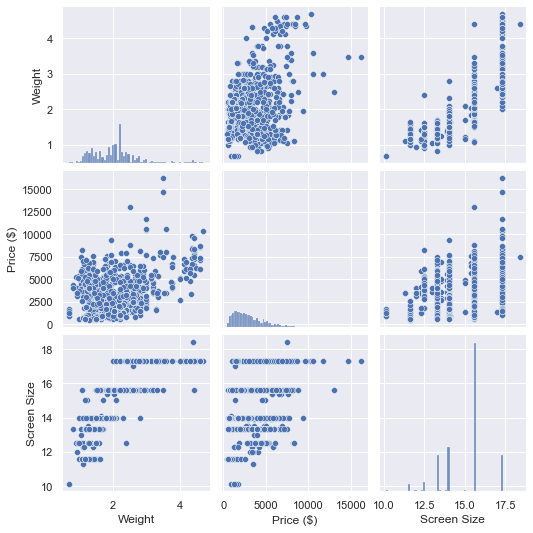

In [24]:
sns.pairplot(data=pc_EDA[['Weight', 'Price ($)', 'Screen Size', 'Operating System']])
plt.show()

## Phik (𝜙k) correlation
Phik (𝜙k) is a correlation coefficient that works consistently between numerical, ordinal variables. This is very useful for this current dataset.

In [25]:
# Aspect ratio as feature??

interval columns not set, guessing: ['Screen Size', 'RAM', 'Weight', 'Price ($)', 'Processor clock speed', 'Pixels (width)', 'Pixels (height)', 'Touchscreen', 'IPS Panel', 'SSD', 'HDD', 'Flash', 'Hybrid', 'ppi']


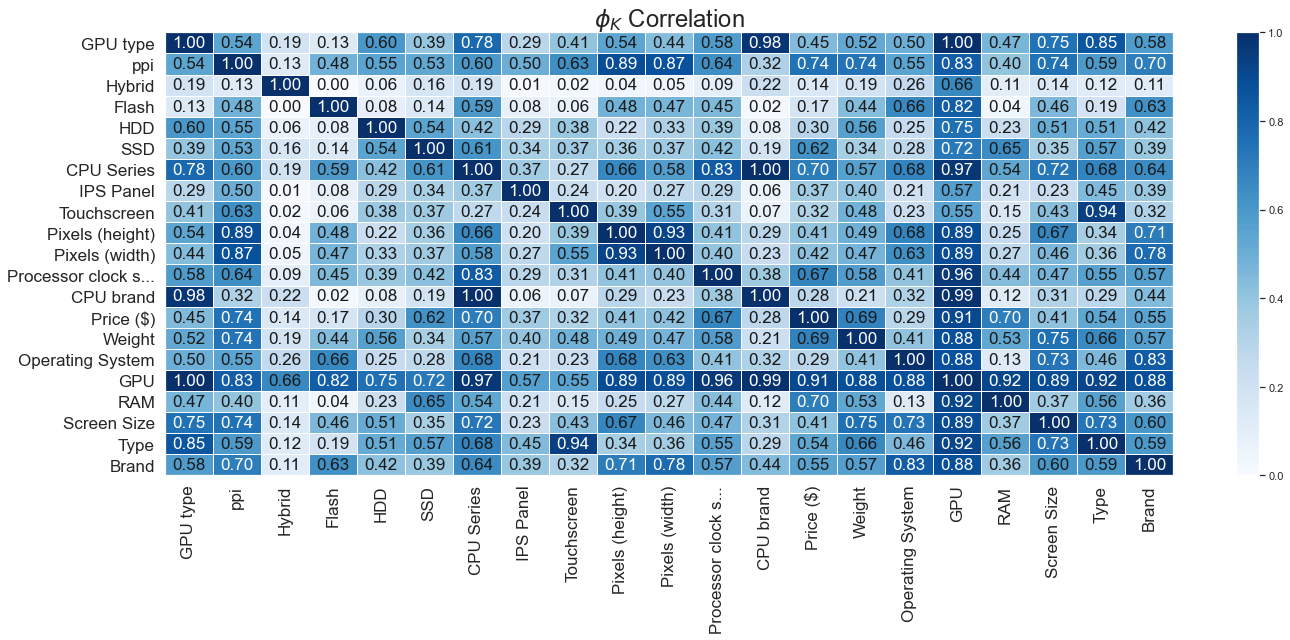

In [26]:
summary = pc_EDA.drop(['Product ID'],axis=1).phik_matrix()
plot_correlation_matrix(summary.values, 
                        x_labels=summary.columns, 
                        y_labels=summary.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"$\phi_K$ Correlation", 
                        fontsize_factor=1.7, 
                        figsize=(20, 9))
plt.show()
# Trees are not affected by multi collinearity

We notice that some features are highly correlated in our model, which may pose a slight problem for our model. 
- Features like pixel width and pixel height are highly correlated.
- This may suggest that there are redundant information in the data, and feature selection can be useful and can benefit our model.
- Features like ['Weight', 'RAM', 'CPU Series', 'PPI',] are highly correlated with target variable (price ($) ).


In [27]:
summary.sort_values(ascending=False, by='Price ($)')['Price ($)'][1:10]

GPU                      0.907569
ppi                      0.744397
CPU Series               0.704720
RAM                      0.700411
Weight                   0.685608
Processor clock speed    0.672709
SSD                      0.622761
Brand                    0.551036
Type                     0.538901
Name: Price ($), dtype: float64

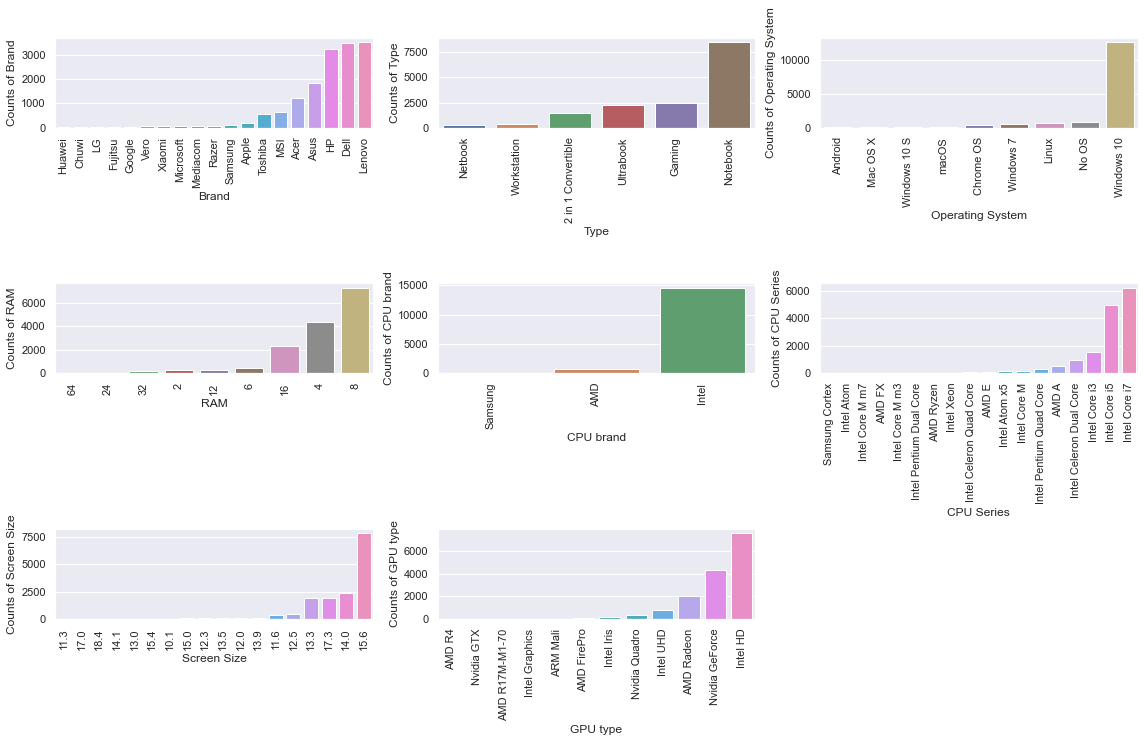

In [28]:
# Univariate analysis
plt.figure(figsize = (16,9))
for y, f in enumerate(['Brand', 'Type', 'Operating System','RAM', 'CPU brand', 'CPU Series', 'Screen Size','GPU type']):
    axc = plt.subplot(3,3,y+1)
    order2 = pc_EDA[f].value_counts().sort_values()
    sns.barplot(x=order2.index, y=order2, ax =axc,order=order2.index)
    plt.xlabel(f)
    plt.ylabel(f'Counts of {f}')
    plt.tight_layout()
    plt.xticks(rotation=90)

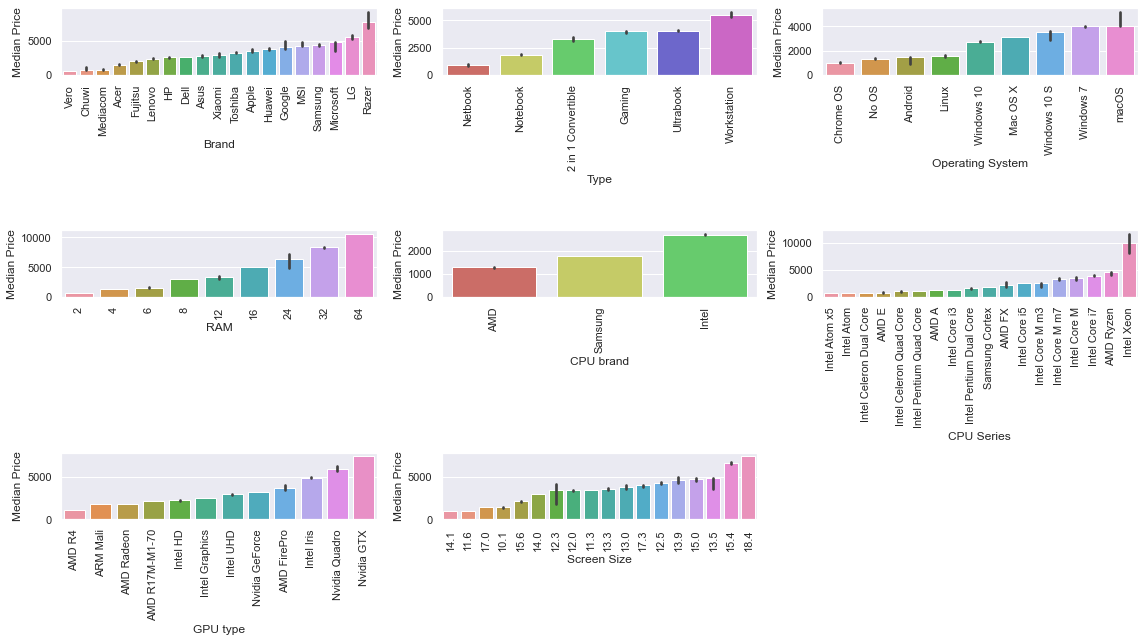

In [29]:
plt.figure(figsize=(16,9))
for i, col in enumerate(['Brand', 'Type', 'Operating System','RAM', 'CPU brand','CPU Series', 'GPU type','Screen Size']):
    sns.set_palette(sns.color_palette("hls"))
    axpr = plt.subplot(3,3,i+1)
    orderby = pc_EDA.groupby(col)['Price ($)'].median().sort_values().index
    # display(orderby)
    sns.barplot(x=col, y ='Price ($)', estimator = np.median, data = pc_EDA, ax = axpr, order=orderby)
    sns.set_style('darkgrid')
    plt.xticks(rotation=90)
    plt.ylabel("Median Price")
    plt.tight_layout()
plt.show()

### Multivariate outlier analysis

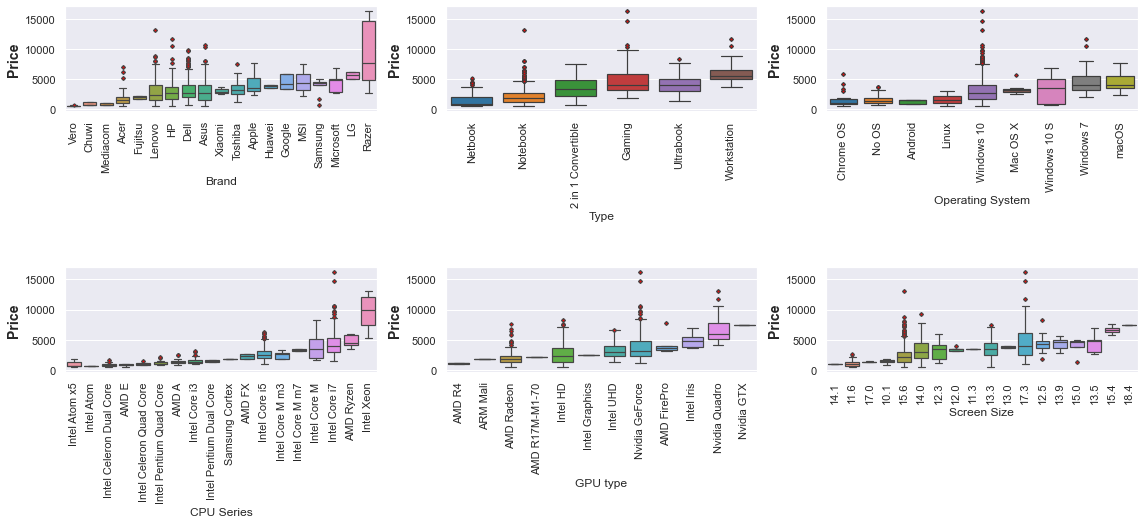

In [30]:
plt.figure(figsize=(16,9))
for o, b in enumerate(['Brand', 'Type', 'Operating System','CPU Series','GPU type','Screen Size']):
    sns.set_palette(sns.color_palette("tab10"))
    axx = plt.subplot(3,3,o+1)
    orderby2 = pc_EDA.groupby(b)['Price ($)'].median().sort_values().index
    sns.boxplot(x=b, y ='Price ($)', data = pc_EDA, ax = axx,order=orderby2,linewidth = 1.2,flierprops = dict(marker = 'o', markersize = 2.5, linestyle = 'none', markerfacecolor = 'red', alpha = 0.75))
    sns.set_style('darkgrid')
    plt.xticks(rotation=90)
    plt.ylabel("Price",fontweight = 'bold', fontsize = 14)
    # plt.title('Boxplots')
    plt.tight_layout()

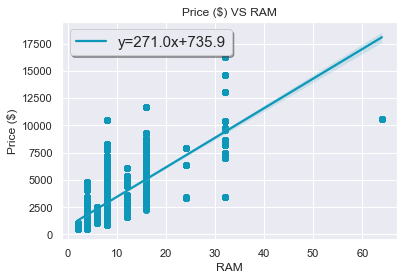

In [31]:
def lr_plot(df, col_x, col_y, leg):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[col_x],df[col_y])
    sns.regplot(x=col_x, y = col_y, data=df, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend(loc=leg, ncol=1, fontsize=15, fancybox=True, shadow=True, frameon=True)
    plt.title(col_y + ' VS ' + col_x)
    plt.show()

lr_plot(pc_EDA,'RAM', 'Price ($)','upper left')

## Performing the same feature engineering on non EDA dataframe
- Keeping the GPU however, as dropping may lead to information loss.
- Dropping the previous GPU type column

In [32]:
pc_df['GPU'] = gpu
pc_df.drop('GPU type',axis=1,inplace=True)

# Separating target label from features.

In [33]:
X ,y = pc_df.drop(['Price ($)', 'Product ID'],axis=1), pc_df['Price ($)']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state =rstate)

In [35]:
class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

numeric_cols = ['ppi','Weight', 'Screen Size', 'RAM', 'Pixels (width)', 'Pixels (height)', 'Processor clock speed', 'SSD', 'HDD', 'Flash', 'Hybrid']
cat_cols = ['CPU brand','CPU Series','Brand', 'Type', 'Operating System', 'GPU','Touchscreen', 'IPS Panel']
pipe = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric_cols),PolynomialFeatures(degree=2) )),
        ('categorical', make_pipeline(Columns(names=cat_cols),OneHotEncoder(handle_unknown='ignore',sparse=False)))
    ]))
])

In [37]:
# As a general rule, we will not call .fit on the test set to prevent data leakage
model = Pipeline([
('Preprocess', pipe),
('RFE', RFE(DecisionTreeRegressor(random_state=rstate),n_features_to_select=0.39)),
('Model', DecisionTreeRegressor(random_state=rstate) )
])
# 96
model.fit(X_train,y_train)

print('mae' , mean_absolute_error(y_test, model.predict(X_test)))
print('rmse' ,mean_squared_error(y_test, model.predict(X_test), squared=False))

print('mse' , mean_squared_error(y_test, model.predict(X_test)))
print('mape' , mean_absolute_percentage_error(y_test, model.predict(X_test)))

display(r2_score(y_test, model.predict(X_test)))

mae 14.191822562684418
rmse 53.54753165090754
mse 2867.3381459049447
mape 0.005533438920722446


0.999175627752797

In [ ]:
def cross_val_scores(model,X_train,y_train,name):
    rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'MSE':'neg_mean_squared_error',
        'r2':'r2',
        'MAPE':'neg_mean_absolute_percentage_error',
        'RMSE': rmse
    }
    scores = cross_validate(model, X_train, y_train, cv = KFold(n_splits = 5, shuffle = True,random_state=rstate), scoring = 
    scoring, return_train_score = True, return_estimator = True, n_jobs= -1)
    scores = pd.DataFrame(scores).append(pd.DataFrame(scores).describe().loc[['mean','max']]).drop(['fit_time', 'score_time'],axis=1).round(4)
    scores['estimator']= name
    return pd.DataFrame(scores), scoring
scores,met = cross_val_scores(model,X_train,y_train,'DecTree')
display(scores)

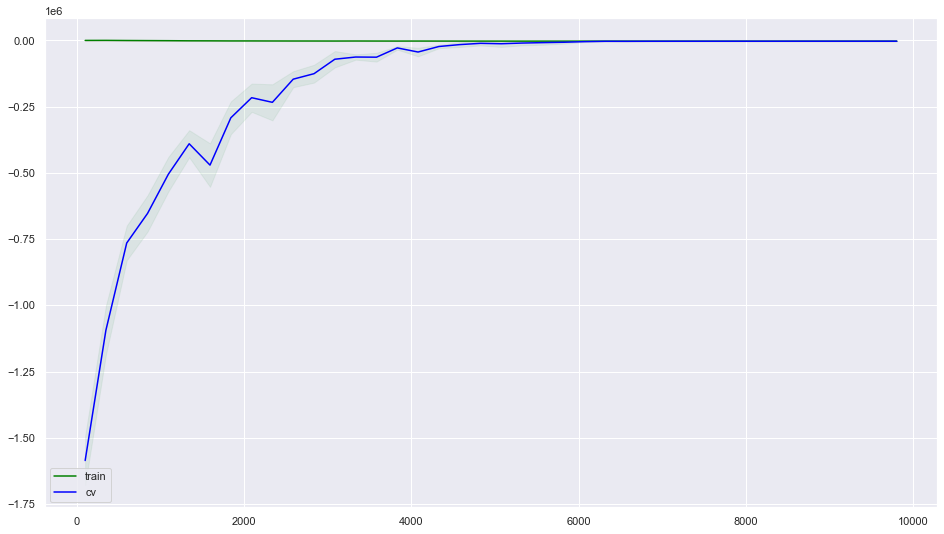

In [ ]:
train_sizes, train_scores, test_scores= learning_curve(
        model,
        X_train,
        y_train,
        cv=5,
        n_jobs=-1,
        train_sizes = np.linspace(0.01, 1, 40),
        scoring= 'neg_mean_squared_error'

    )

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
print()
plt.figure(figsize = (16,9))
plt.plot(train_sizes ,train_scores_mean , c =  'green' , label = 'train'  )

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes ,test_scores_mean , c =  'blue' , label = 'cv'  )
plt.legend()
plt.show()

In [ ]:
# param = {'Model__max_depth' : [35,40,50,25,20],
#            'Model__n_estimators': [325,200,400,250],
#         #    'Model__min_samples_split': [2],
#         #    'Model__min_samples_leaf': [2],
#            'Model__bootstrap': [False,True],
#           #  'Model__criterion':['entropy', 'gini'],
#          #   'Model__max_depth': [21,20]
#            }

# param = {
#     'Model__criterion': ['squared_error', 'absolute_error'],
#     'Model__max_features': ['auto', 'log2', 'sqrt', None],
# }
# # param_dist = {"max_depth": [3, None],
#             #   "max_features": randint(1, 9),
#             #   "min_samples_leaf": randint(1, 9),
#             #   "criterion": ["gini", "entropy"]}
# grid = GridSearchCV(model, param,cv =2 ,n_jobs=-1,scoring='neg_mean_squared_error', verbose=6)
# grid.fit(X_train,y_train)
# # grid.best_params_
# grid.best_score_

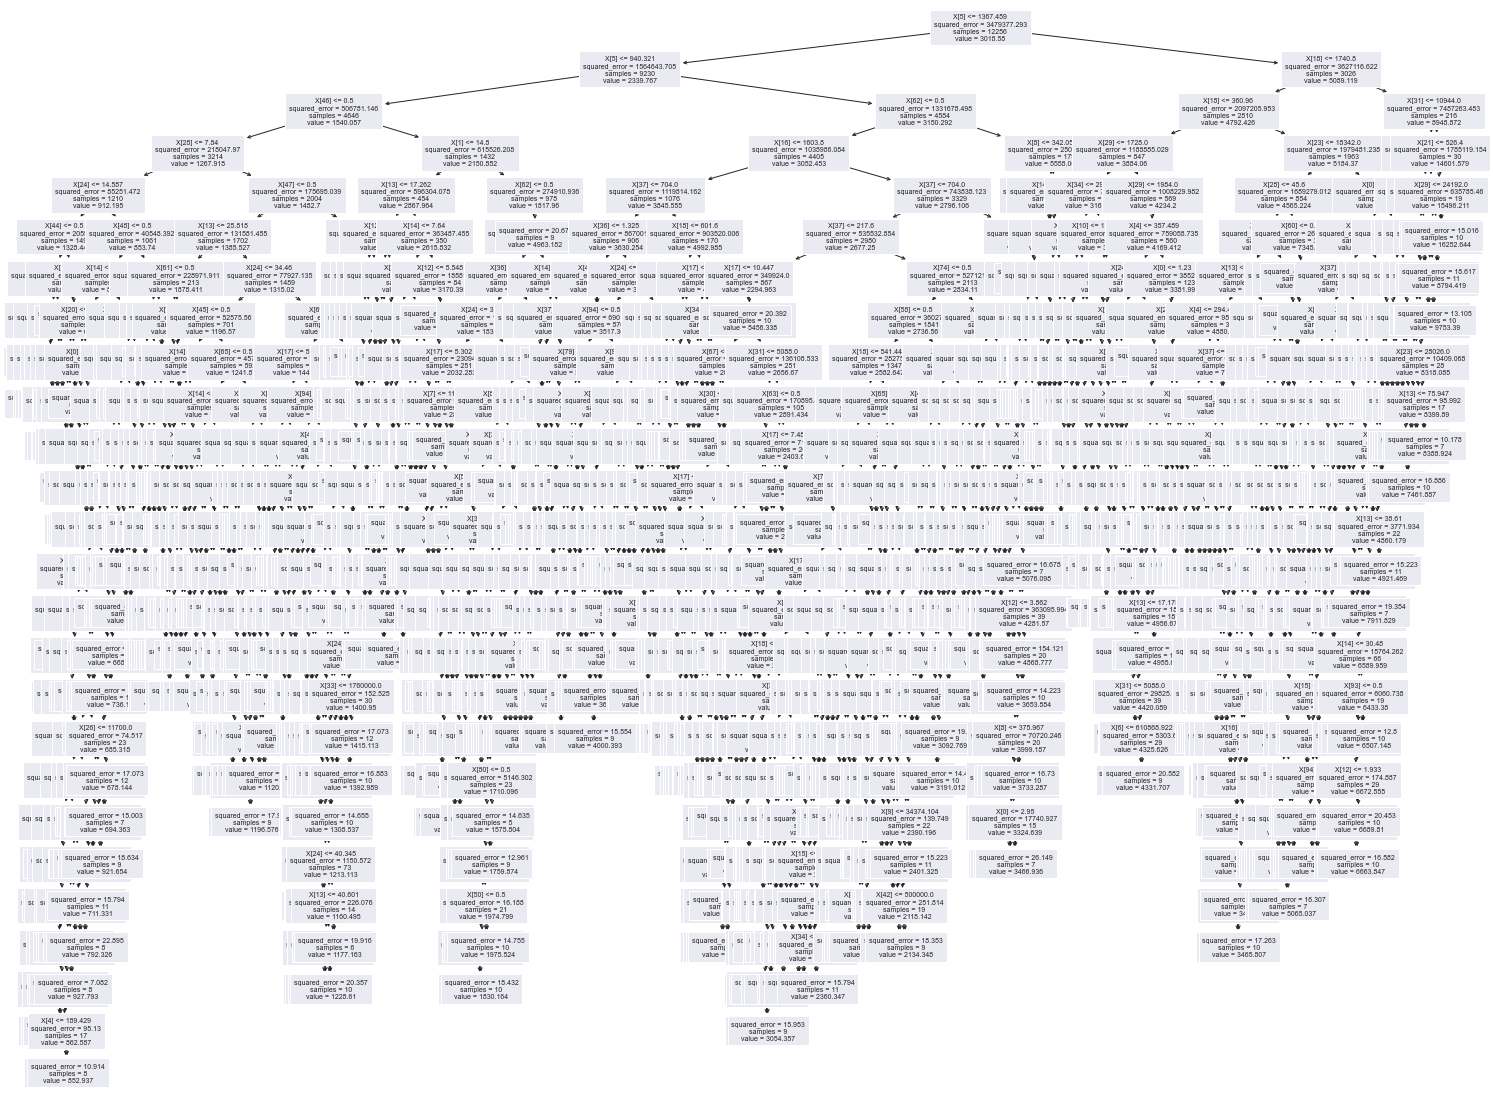

In [46]:
figtree, axtree = plt.subplots(figsize=(25, 20))
plot_tree(model['Model'], fontsize=7)
plt.show()